# ch 9 Simple DNN

이번 챕터에서는 이론으로 배운 딥러닝 모델을 간단히 구현해보겠습니다. 이전 펭귄 클래시피케이션 모델을 다층 신경망 방식으로 구현해보겠습니다. pytorch의 도움을 받으면 어렵지않게 구현할 수 있습니다.

## 데이터 셋 준비

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

df = pd.read_csv("./data/penguins_preprocessed.csv")
X = df.drop(["species"], axis=1)
y = df["species"]
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [3]:
x_train = torch.Tensor(x_train.values)
y_train = torch.Tensor(y_train.values).type(torch.long) 
x_val = torch.Tensor(x_val.values)
y_val = torch.Tensor(y_val.values).type(torch.long) 

## Deep Neural Network

### 모델 작성

In [4]:
import torch

class SimpleDNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x 

### 하이퍼 파라미터 셋팅

In [5]:
input_dim = x_train.shape[1]
output_dim = len(y_train.unique())
hidden_dim = 10

In [6]:
model = SimpleDNN(input_dim, hidden_dim, output_dim)
learning_rate = 0.01 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss() 
epochs = 100

In [7]:
x_train

tensor([[ 1.5050, -0.0308,  1.9273,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.8264,  0.1728, -0.7153,  ...,  1.0000,  0.0000,  1.0000],
        [-0.3291,  1.1906, -0.2868,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 1.3399,  1.3942, -0.2153,  ...,  1.0000,  0.0000,  1.0000],
        [-0.5675,  0.8853, -1.2153,  ...,  1.0000,  0.0000,  1.0000],
        [-1.1544, -0.5906, -1.2867,  ...,  0.0000,  0.0000,  0.0000]])

### 모델 학습

In [8]:
from sklearn.metrics import accuracy_score
from collections import defaultdict 

logs = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # inference, calculate loss
    outputs = model(x_train)
    pred = torch.argmax(outputs, dim=1)
    accuracy = accuracy_score(y_train, pred)
    loss = criterion(outputs, y_train)
    
    # paramter optimize
    loss.backward()
    optimizer.step()

    # validation
    with torch.no_grad():
        val_outputs = model(x_val)
        val_pred = torch.argmax(val_outputs, dim=1)
        val_loss = criterion(val_outputs, y_val)
        val_accuracy = accuracy_score(y_val, val_pred)
    
    logs["train_loss"].append(loss.item())
    logs["train_accuracy"].append(accuracy)
    logs["val_loss"].append(val_loss.item())
    logs["val_accuracy"].append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"epoch: {epoch + 1} train - loss: {round(loss.item(), 4)} acc: {round(accuracy, 4)} "\
                 f"val - loss: {round(val_loss.item(), 4)} acc: {round(val_accuracy, 4)}")

epoch: 10 train - loss: 1.0556 acc: 0.427 val - loss: 1.0209 acc: 0.4776
epoch: 20 train - loss: 0.9939 acc: 0.4345 val - loss: 0.9442 acc: 0.5522
epoch: 30 train - loss: 0.9026 acc: 0.7828 val - loss: 0.8375 acc: 0.8507
epoch: 40 train - loss: 0.826 acc: 0.7828 val - loss: 0.7544 acc: 0.8507
epoch: 50 train - loss: 0.7853 acc: 0.7828 val - loss: 0.7147 acc: 0.8507
epoch: 60 train - loss: 0.7591 acc: 0.7828 val - loss: 0.6937 acc: 0.8507
epoch: 70 train - loss: 0.7287 acc: 0.7828 val - loss: 0.6783 acc: 0.8507
epoch: 80 train - loss: 0.6954 acc: 0.9551 val - loss: 0.6624 acc: 1.0
epoch: 90 train - loss: 0.6589 acc: 0.9775 val - loss: 0.632 acc: 1.0
epoch: 100 train - loss: 0.628 acc: 0.9888 val - loss: 0.6076 acc: 1.0


### 결과 시각화

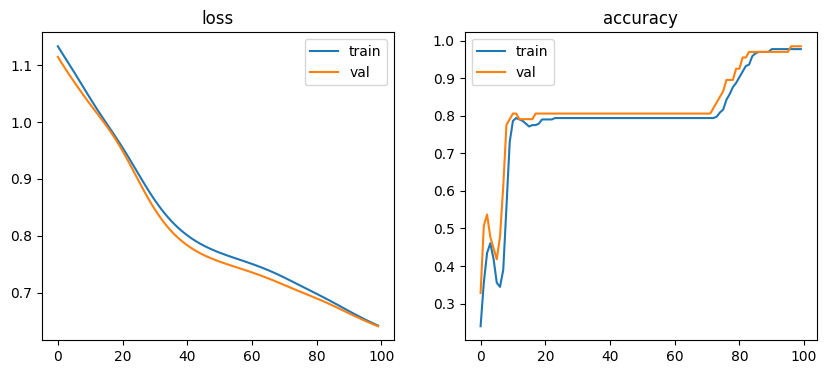

In [16]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 4))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
ax0.plot(logs["train_loss"], label="train")
ax0.plot(logs["val_loss"], label="val")
ax0.legend()
ax0.set_title("loss")

ax1.plot(logs["train_accuracy"], label="train")
ax1.plot(logs["val_accuracy"], label="val")
ax1.legend()
ax1.set_title("accuracy")
plt.legend()

## 정리

이번 챕터에서는 이론으로만 배웠던 딥러닝을 실제로 구현해보았습니다. 그 결과, 지금까지 우리가 linear regression이나 logistic regression을 Grandient Descent 방식으로 학습시킨 코드와 그다지 다르지 않았습니다. 차이가 있다면 신경망 레이어를 여러 겹 쌓고, 그 사이 사이에 비선형 함수인 sigmoid를 끼워넣은 모델이라는 점입니다. 선형 레이어 사이 사이에 비선형성을 넣어준다는 점을 꼭 기억해주시고 넘어가시기 바랍니다.